In [88]:
import sys
sys.path.insert(0, '..')

# =====================================================
# EXPLORATORY ANALYSIS: METRICS OVER TIME
# =====================================================
# This notebook analyzes how metrics changes over time
# for different player types, with 95% confidence intervals.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Import utility functions from plot_utilities
from plot_utilities import (
    load_turn_data,
    setup_notebook_display,
    plot_bar_chart,
    plot_forest_plot,
    prepare_coefficient_data,
    plot_metric_over_time  # Generalized function for any metric
)

# Set up notebook display and plotting style
setup_notebook_display(figsize=(12, 6))

# Load turn data with player type mapping automatically applied
PREDICTIONS_CSV = '../models/output/attention_mlp_predictions.csv'
turn_df = load_turn_data(PREDICTIONS_CSV, condition_exclude=[])

✓ Loaded turn data: 1875256 rows
✓ Filters applied: condition_exclude=[]
✓ Unique conditions: 15
✓ Unique player types: 16
✓ Turn range: 0 - 500
✓ Unique civilizations: 43

Player Type Distribution:
  Vanilla: 1076064 rows (57.4%)
  Null: 89336 rows (4.8%)
  GLM-4.7-Simple: 75725 rows (4.0%)
  GLM-4.7-Briefed: 75725 rows (4.0%)
  Kimi-K2.5-Briefed: 71212 rows (3.8%)
  Kimi-K2.5-Simple: 71212 rows (3.8%)
  GPT-OSS-120B-Simple: 65948 rows (3.5%)
  GPT-OSS-120B-Briefed: 65948 rows (3.5%)
  Minimax-M2.5-Simple: 50190 rows (2.7%)
  Minimax-M2.5-Briefed: 50190 rows (2.7%)
  Deepseek-3.2-Simple: 48321 rows (2.6%)
  Deepseek-3.2-Briefed: 48321 rows (2.6%)
  Qwen-3.5-Briefed: 32340 rows (1.7%)
  Qwen-3.5-Simple: 32340 rows (1.7%)
  Sonnet-4.5-Briefed: 11192 rows (0.6%)
  Sonnet-4.5-Simple: 11192 rows (0.6%)

Condition Distribution:
  observe-vanilla-standard: 656064 rows (35.0%)
  2026-deepseek-v-kimi2-v-glm-standard: 281688 rows (15.0%)
  2026-oss-v-glm-standard: 223776 rows (11.9%)
  2026-nul

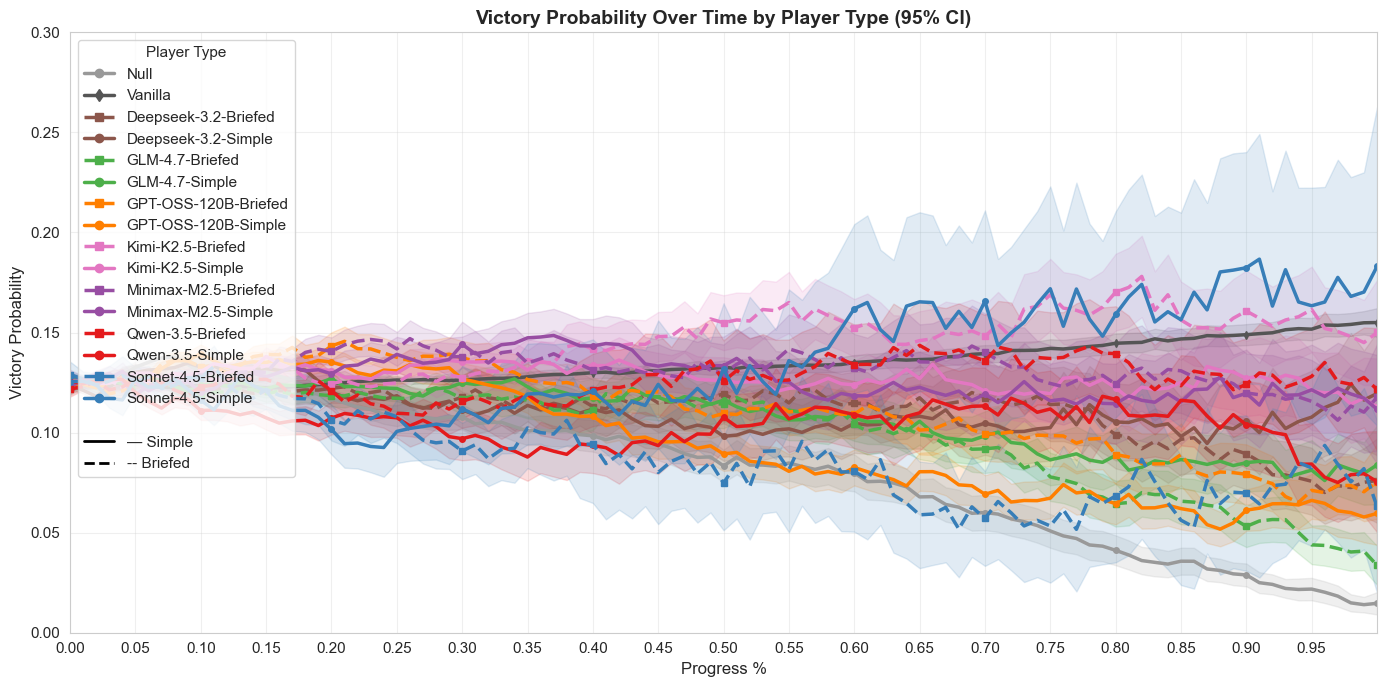

N   Mean    Std  Min    Max     Slope      r
Null                    89336  0.082  0.110  0.0  0.939 -0.123867 -0.326
Vanilla               1076064  0.134  0.187  0.0  1.000  0.031996  0.049
Deepseek-3.2-Briefed    48321  0.111  0.154  0.0  0.996 -0.039621 -0.075
Deepseek-3.2-Simple     48321  0.112  0.160  0.0  1.000 -0.024923 -0.045
GLM-4.7-Briefed         75725  0.099  0.139  0.0  1.000 -0.080912 -0.168
GLM-4.7-Simple          75725  0.108  0.147  0.0  0.999 -0.054259 -0.107
GPT-OSS-120B-Briefed    65948  0.112  0.148  0.0  0.985 -0.070010 -0.136
GPT-OSS-120B-Simple     65948  0.096  0.117  0.0  0.985 -0.094286 -0.232
Kimi-K2.5-Briefed       71212  0.145  0.187  0.0  1.000  0.041525  0.064
Kimi-K2.5-Simple        71212  0.128  0.169  0.0  1.000 -0.010534 -0.018
Minimax-M2.5-Briefed    50190  0.131  0.172  0.0  0.997 -0.012282 -0.021
Minimax-M2.5-Simple     50190  0.127  0.174  0.0  1.000 -0.018041 -0.030
Qwen-3.5-Briefed        32340  0.127  0.170  0.0  0.995  0.015422  0.026
Qwen-3.5-Simple         32340  0.105  0.144  0.0  1.000 -0.012133 -0.024
Sonnet-4.5-Briefed      11192  0.088  0.145  0.0  0.998 -0.065086 -0.128
Sonnet-4.5-Simple       11192  0.137  0.207  0.0  0.995  0.076922  0.107

In [89]:
fig, ax = plot_metric_over_time(
    turn_df,
    metric_calculation=lambda df: df['predicted_win_probability'],
    title="Victory Probability Over Time by Player Type",
    ylabel="Victory Probability",
    figsize=(14, 7),
    show_confidence=True,
    confidence_level=0.95,
    print_summary=True,
    use_turn_progress=True,
    ylim=(0, 0.3),
    legend_loc='upper left'
)

In [90]:
# =====================================================
# PLAYER STRENGTH: COMPUTE VIA CENTRALIZED PIPELINE
# =====================================================
# Uses the canonical prepare_strength_data() from ratings/iterative_bt.py
# Pipeline: weighted avg (late-game) → relative to game leader →
# winner adjustment → OLS civ effects → civ-adjusted strength → filter non-LLM

from ratings.iterative_bt import prepare_strength_data

strength_df, civ_effects, model = prepare_strength_data(PREDICTIONS_CSV)

# Show per-player-type summary
player_level = strength_df.groupby('player_type').agg(
    player_type=('player_type', 'first'),
    relative_strength=('relative_strength', 'mean'),
)
print(player_level)

Loading turn data...
  1875256 rows, 551 games
Computing weighted strength per player...
Enforced winner relative_strength=1.0 in 146/551 games (26.5%); avg relative_strength change = 0.4301
Fitting OLS for civilization effects (logit scale)...
  357 games after excluding non-LLM experiments
                               player_type  relative_strength
player_type                                                  
Deepseek-3.2-Briefed  Deepseek-3.2-Briefed           0.218002
Deepseek-3.2-Simple    Deepseek-3.2-Simple           0.212265
GLM-4.7-Briefed            GLM-4.7-Briefed           0.174649
GLM-4.7-Simple              GLM-4.7-Simple           0.188534
GPT-OSS-120B-Briefed  GPT-OSS-120B-Briefed           0.206830
GPT-OSS-120B-Simple    GPT-OSS-120B-Simple           0.187031
Kimi-K2.5-Briefed        Kimi-K2.5-Briefed           0.341522
Kimi-K2.5-Simple          Kimi-K2.5-Simple           0.261307
Minimax-M2.5-Briefed  Minimax-M2.5-Briefed           0.286239
Minimax-M2.5-Simple    Mi

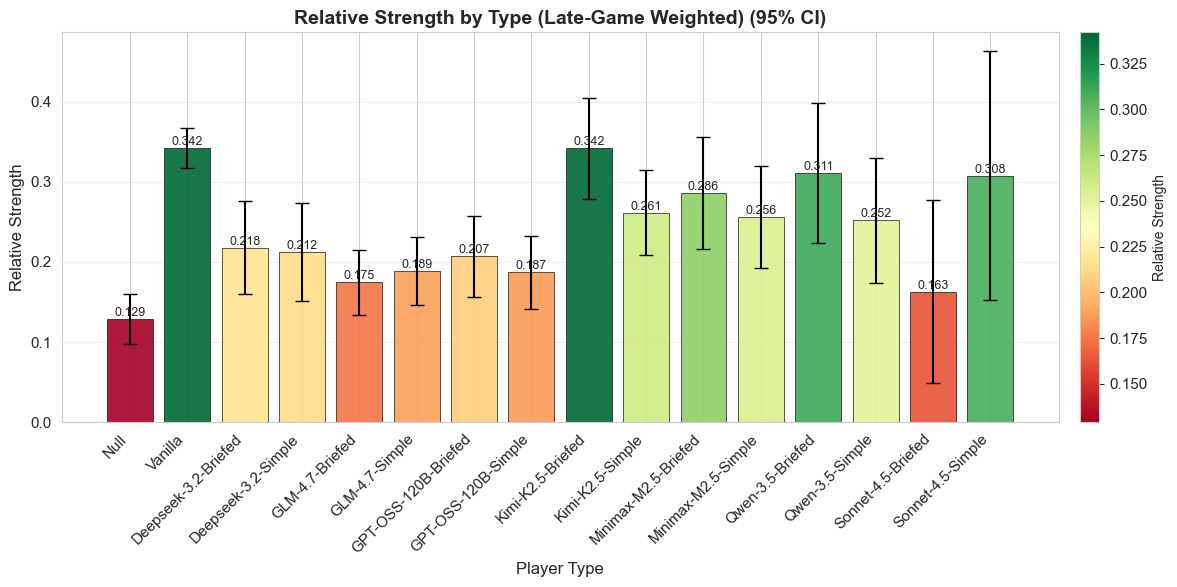

Mean       Std    N
Null                  0.129050  0.227820  200
Vanilla               0.342050  0.405170  982
Deepseek-3.2-Briefed  0.218002  0.311951  113
Deepseek-3.2-Simple   0.212265  0.333383  113
GLM-4.7-Briefed       0.174649  0.277705  179
GLM-4.7-Simple        0.188534  0.291709  179
GPT-OSS-120B-Briefed  0.206830  0.318753  156
GPT-OSS-120B-Simple   0.187031  0.290909  156
Kimi-K2.5-Briefed     0.341522  0.413121  167
Kimi-K2.5-Simple      0.261307  0.348953  167
Minimax-M2.5-Briefed  0.286239  0.385126  118
Minimax-M2.5-Simple   0.256114  0.354425  118
Qwen-3.5-Briefed      0.310941  0.391121   76
Qwen-3.5-Simple       0.251905  0.348348   76
Sonnet-4.5-Briefed    0.162954  0.308399   28
Sonnet-4.5-Simple     0.307737  0.419850   28

In [91]:
# Plot bar chart of average relative strength by player type
plot_bar_chart(
    strength_df,
    category_col='player_type',
    value_col='relative_strength',
    use_percentage=False,
    xlabel='Player Type',
    ylabel='Relative Strength',
    title='Relative Strength by Type (Late-Game Weighted)',
    show_error_bars=True,
    confidence_level=0.95,
    value_format='{:.3f}',
    rotation=45,
    colormap='RdYlGn',
    figsize=(12, 6)
)

In [92]:
# =====================================================
# OLS MODEL SUMMARY
# =====================================================
# The OLS model was already fitted inside prepare_strength_data().
# Display its summary here for inspection.
# Note: The dependent variable is logit(relative_strength), so
# coefficients are in log-odds units.

print("=" * 60)
print("LINEAR REGRESSION: logit(relative_strength)")
print("=" * 60)
print("\nModel: Civilization (Sum) + Player Type (Treatment, ref=Vanilla)")
print(model.summary())

LINEAR REGRESSION: logit(relative_strength)

Model: Civilization (Sum) + Player Type (Treatment, ref=Vanilla)
                            OLS Regression Results                            
Dep. Variable:         logit_strength   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     10.43
Date:                Thu, 26 Mar 2026   Prob (F-statistic):           6.67e-84
Time:                        01:52:21   Log-Likelihood:                -13573.
No. Observations:                4408   AIC:                         2.726e+04
Df Residuals:                    4350   BIC:                         2.763e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err        

In [93]:
# =====================================================
# VARIANCE DECOMPOSITION: CIVILIZATION vs. STRATEGIST
# =====================================================
# How much of the variation in logit(relative_strength) is explained
# by civilization alone vs. player type (strategist) alone?

from statsmodels.formula.api import ols as smols
from plot_utilities import logit

# Recover the exact data the combined model was fitted on, recreate logit DV
fit_df = model.model.data.frame.copy()
fit_df = fit_df[fit_df['player_type'].isin(['Vanilla', 'Null']) == False]
fit_df['logit_strength'] = logit(fit_df['relative_strength'])

# Fit single-factor models
civ_model = smols('logit_strength ~ C(civilization, Sum)', data=fit_df).fit()
pt_model = smols('logit_strength ~ C(player_type, Sum)', data=fit_df).fit()

# Print comparison table
print("=" * 60)
print("VARIANCE EXPLAINED: logit(relative_strength)")
print("=" * 60)
header = f"  {'Factor':<30} {'R²':>8}  {'Adj. R²':>8}  {'df':>4}"
print(header)
print(f"  {'-'*30} {'-'*8}  {'-'*8}  {'-'*4}")
print(f"  {'Civilization only':<30} {civ_model.rsquared:>8.4f}  {civ_model.rsquared_adj:>8.4f}  {int(civ_model.df_model):>4}")
print(f"  {'Player type only':<30} {pt_model.rsquared:>8.4f}  {pt_model.rsquared_adj:>8.4f}  {int(pt_model.df_model):>4}")
print(f"  {'Combined (civ + player type)':<30} {model.rsquared:>8.4f}  {model.rsquared_adj:>8.4f}  {int(model.df_model):>4}")
print(f"  N = {int(model.nobs)}")

VARIANCE EXPLAINED: logit(relative_strength)
  Factor                               R²   Adj. R²    df
  ------------------------------ --------  --------  ----
  Civilization only                0.1185    0.0958    42
  Player type only                 0.0235    0.0158    13
  Combined (civ + player type)     0.1203    0.1087    57
  N = 4408


In [94]:
# =====================================================
# PREPARE DATA FOR VISUALIZATION
# =====================================================
# Extract coefficients and prepare data for forest plots using utility functions

# Get model results
params = model.params
conf_int = model.conf_int()
pvalues = model.pvalues

# Extract and prepare condition effects (LLM strategist)
condition_vars = [col for col in params.index if 'player_type' in col and col != 'Intercept']
condition_df = prepare_coefficient_data(params, conf_int, pvalues, condition_vars, var_type='condition')

# Extract and prepare civilization effects
civ_vars = [col for col in params.index if 'civilization' in col]
civ_df = prepare_coefficient_data(params, conf_int, pvalues, civ_vars, var_type='civilization')


Effect of LLM Strategist on Relative Strength
(95% Confidence Intervals) SUMMARY

Baseline: (Vanilla baseline)

Statistically Significant Effects (p < 0.05):
----------------------------------------
  Deepseek-3.2-Briefed           -1.410 [-2.413, -0.407] **
  Deepseek-3.2-Simple            -1.326 [-2.331, -0.321] **
  GLM-4.7-Briefed                -1.731 [-2.538, -0.925] ***
  GLM-4.7-Simple                 -1.354 [-2.162, -0.547] **
  GPT-OSS-120B-Briefed           -1.146 [-2.004, -0.287] **
  GPT-OSS-120B-Simple            -1.353 [-2.213, -0.493] **
  Kimi-K2.5-Simple               -0.923 [-1.756, -0.090] *
  Null                           -2.542 [-3.309, -1.775] ***

Non-Significant Effects:
----------------------------------------
  Kimi-K2.5-Briefed              +0.773 [-0.060, +1.605]
  Minimax-M2.5-Briefed           +0.381 [-0.602, +1.364]
  Minimax-M2.5-Simple            -0.390 [-1.373, +0.592]
  Qwen-3.5-Briefed               +0.206 [-1.008, +1.420]
  Qwen-3.5-Simple       

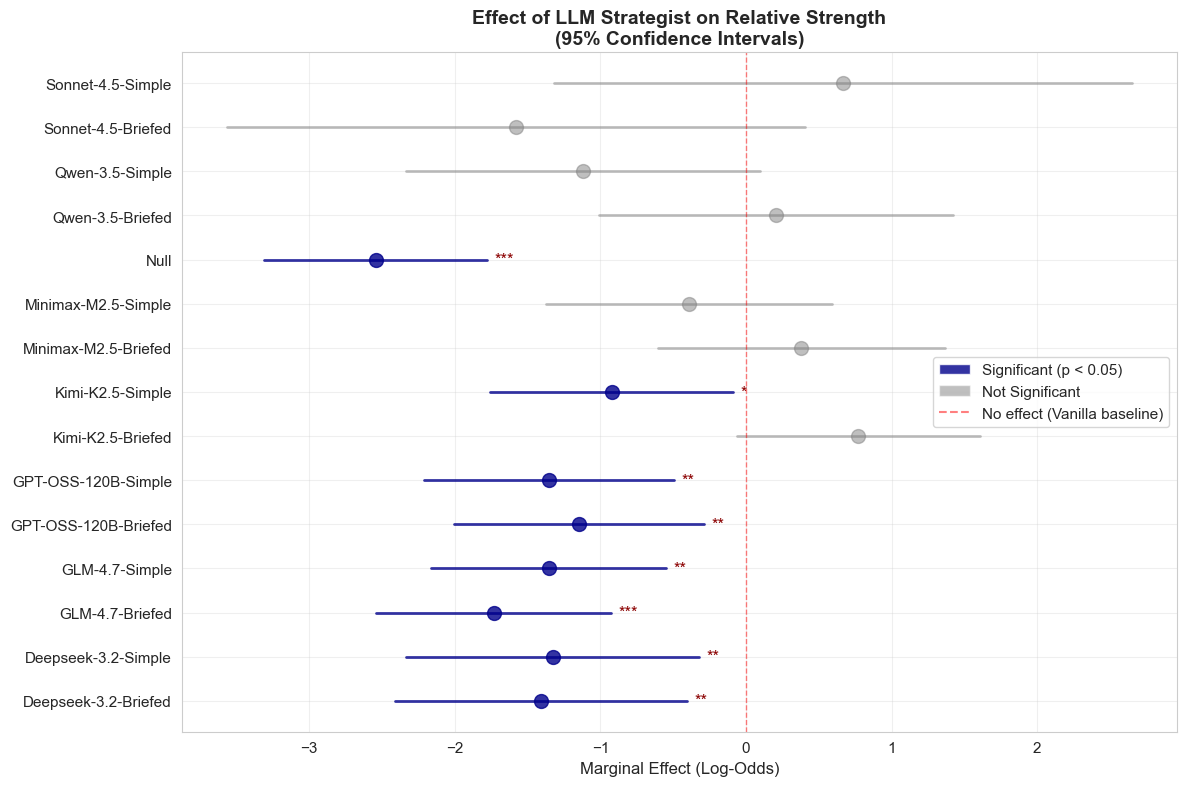

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Effect of LLM Strategist on Relative Strength\n(95% Confidence Intervals)'}, xlabel='Marginal Effect (Log-Odds)'>)

In [95]:
# =====================================================
# VISUALIZATION 1: LLM STRATEGIST EFFECTS
# =====================================================
# Create forest plot showing how LLM strategists affect score ratio
# compared to vanilla gameplay (no LLM strategist)

# Create forest plot for conditions with integrated summary
plot_forest_plot(
    condition_df, 
    title='Effect of LLM Strategist on Relative Strength\n(95% Confidence Intervals)',
    xlabel='Marginal Effect (Log-Odds)',
    color='darkblue',
    figsize=(12, 8),
    reference_line_label='No effect (Vanilla baseline)',
    use_prob_scale=False,  # Use raw scale for score ratio
    sort_alphabetically=True
)


Civilization Effects on Relative Strength
(Relative to Mean, 95% Confidence Intervals) SUMMARY

Baseline: Average of all civilization effect

Statistically Significant Effects (p < 0.05):
----------------------------------------
  Assyria                        -2.962 [-3.961, -1.963] ***
  Mongolia                       -2.849 [-3.852, -1.846] ***
  Denmark                        -2.401 [-3.396, -1.406] ***
  Persia                         -2.395 [-3.323, -1.466] ***
  Rome                           -2.241 [-3.202, -1.280] ***
  America                        -2.078 [-3.016, -1.141] ***
  Japan                          -2.067 [-3.004, -1.130] ***
  England                        -1.941 [-3.048, -0.835] ***
  The Huns                       -1.456 [-2.465, -0.447] **
  The Aztecs                     -1.292 [-2.356, -0.228] *
  The Ottomans                   -1.186 [-2.158, -0.215] *
  France                         -1.175 [-2.207, -0.142] *
  Sweden                         -1.157 [-2.2

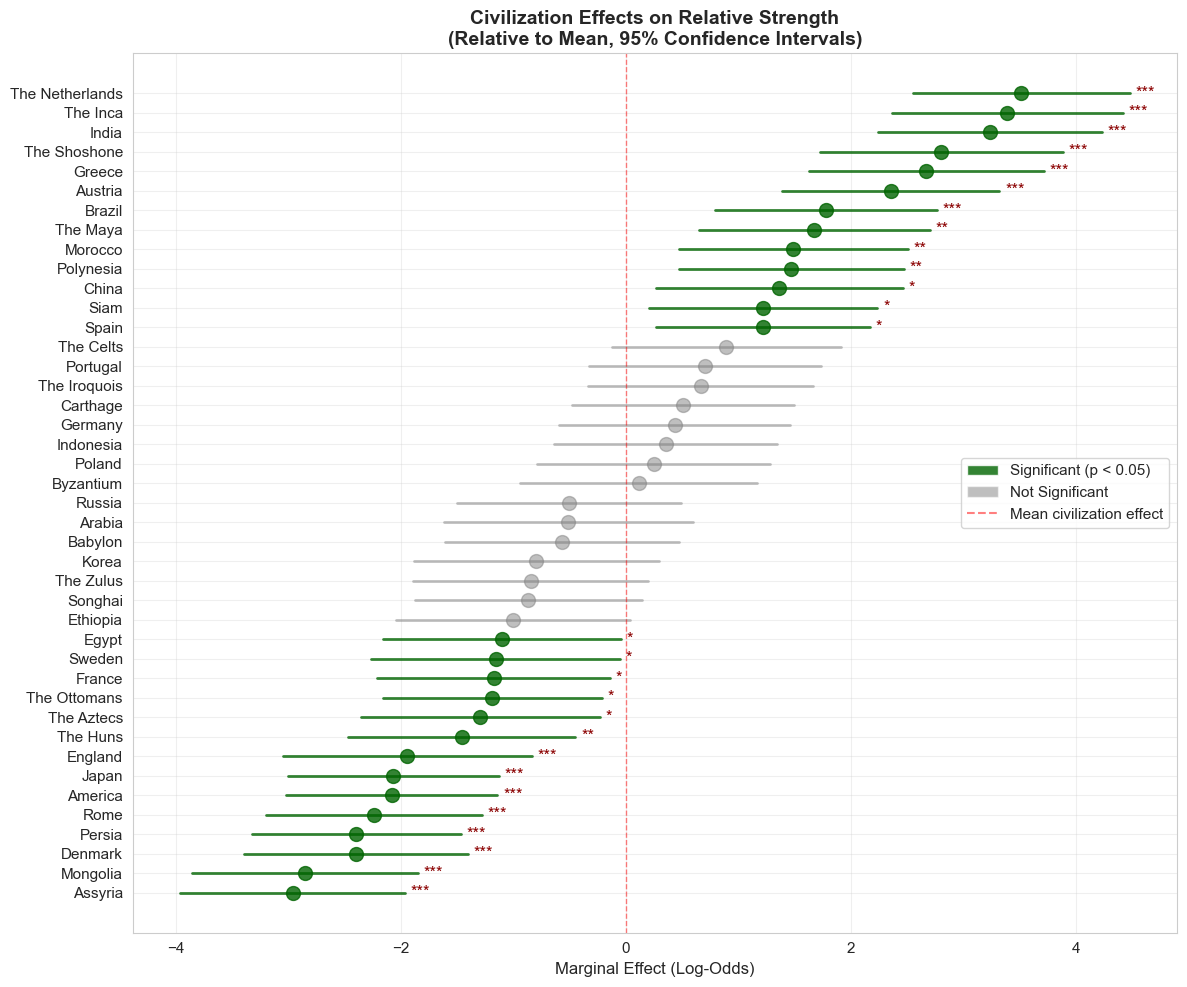

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Civilization Effects on Relative Strength\n(Relative to Mean, 95% Confidence Intervals)'}, xlabel='Marginal Effect (Log-Odds)'>)

In [96]:
# =====================================================
# VISUALIZATION 2: CIVILIZATION EFFECTS (RELATIVE TO MEAN)
# =====================================================
# Create forest plot showing civilization strength relative to the mean
# This approach uses the average civilization performance as the baseline

# Create forest plot for civilizations with integrated summary
plot_forest_plot(
    civ_df,
    title='Civilization Effects on Relative Strength\n(Relative to Mean, 95% Confidence Intervals)',
    xlabel='Marginal Effect (Log-Odds)',
    color='darkgreen',
    figsize=(12, 10),
    reference_line_label='Mean civilization effect',
    use_prob_scale=False,  # Use raw scale for score ratio
)

In [97]:
# =====================================================
# EXPORT: MERGED STRENGTH + PANEL DATA
# =====================================================
# Merge player strength metrics with panel-level behavioral data
# and save as a per-game-player CSV for downstream analysis

from plot_utilities import load_panel_data

panel_df = load_panel_data('../panel_data.csv', condition_exclude=[], print_metadata=False)

merged_df = strength_df.merge(
    panel_df,
    on=['game_id', 'player_id'],
    how='left',
    suffixes=('', '_panel')
)

# Drop duplicate columns from panel side
drop_cols = [c for c in merged_df.columns if c.endswith('_panel')]
merged_df = merged_df.drop(columns=drop_cols)

# Derived columns for downstream analysis
merged_df['strategy_change_rate'] = merged_df['strategy_changes'] / merged_df['survival_turn']
merged_df['persona_change_rate'] = merged_df['persona_changes'] / merged_df['survival_turn']

output_path = 'player_strength_panel.csv'
merged_df.to_csv(output_path, index=False)
print(f"✓ Saved {len(merged_df)} rows × {len(merged_df.columns)} columns to {output_path}")
print(f"  Player types: {merged_df['player_type'].nunique()}")
print(f"  Games: {merged_df['game_id'].nunique()}")

# Verify merge integrity
n_missing = merged_df['score'].isna().sum()
if n_missing > 0:
    print(f"  ⚠ {n_missing} rows missing panel data after merge")
else:
    print(f"  ✓ All rows matched with panel data")

✓ Saved 2856 rows × 49 columns to player_strength_panel.csv
  Player types: 16
  Games: 357
  ✓ All rows matched with panel data


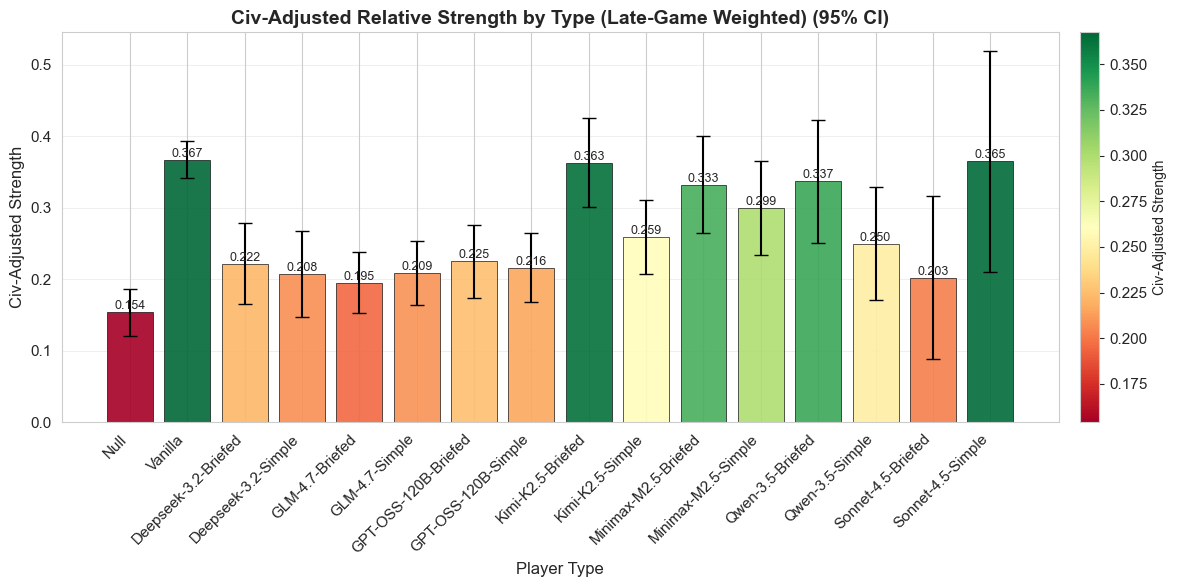

Mean       Std    N
Null                  0.153973  0.237565  200
Vanilla               0.367421  0.407921  982
Deepseek-3.2-Briefed  0.221901  0.307538  113
Deepseek-3.2-Simple   0.207504  0.325269  113
GLM-4.7-Briefed       0.195040  0.291256  179
GLM-4.7-Simple        0.209079  0.304588  179
GPT-OSS-120B-Briefed  0.225225  0.324877  156
GPT-OSS-120B-Simple   0.216492  0.309845  156
Kimi-K2.5-Briefed     0.363381  0.410054  167
Kimi-K2.5-Simple      0.259238  0.344781  167
Minimax-M2.5-Briefed  0.332524  0.378001  118
Minimax-M2.5-Simple   0.299347  0.365053  118
Qwen-3.5-Briefed      0.337375  0.383530   76
Qwen-3.5-Simple       0.249763  0.350700   76
Sonnet-4.5-Briefed    0.202511  0.309568   28
Sonnet-4.5-Simple     0.365107  0.417221   28

In [98]:
# Plot bar chart of average weighted strength by player type
plot_bar_chart(
    strength_df,
    category_col='player_type',
    value_col='adjusted_strength',
    use_percentage=False,
    xlabel='Player Type',
    ylabel='Civ-Adjusted Strength',
    title='Civ-Adjusted Relative Strength by Type (Late-Game Weighted)',
    show_error_bars=True,
    confidence_level=0.95,
    value_format='{:.3f}',
    rotation=45,
    colormap='RdYlGn',
    figsize=(12, 6)
)

In [99]:
# =====================================================
# RATING CALCULATION: USING Score-weighted BT
# =====================================================
# Calculate player ratings using BT (Bradley-Terry)
# with continuous pairwise strength comparisons (not ordinal rankings)

from ratings import calculate_ratings, calculate_ratings_bt, compare_with_ols

# Calculate ratings with BT
rating_summary_df = calculate_ratings_bt(
    strength_df,
    verbose=True,
    margin=0.125
)

# Save the canonical general-purpose Elo table for downstream notebooks.
rating_summary_df = rating_summary_df.copy()
rating_summary_df['n_games'] = rating_summary_df['player_type'].map(
    strength_df.groupby('player_type')['game_id'].nunique()
)
orthodox_elo_path = '../ratings/output/orthodox_elo_ratings.csv'
rating_summary_df.to_csv(orthodox_elo_path, index=False)
print(f"Saved {len(rating_summary_df)} orthodox Elo ratings to {orthodox_elo_path}")

CALCULATING RATINGS USING BRADLEY-TERRY MLE (R)

Total games: 357
Player types: ['Deepseek-3.2-Briefed', 'Deepseek-3.2-Simple', 'GLM-4.7-Briefed', 'GLM-4.7-Simple', 'GPT-OSS-120B-Briefed', 'GPT-OSS-120B-Simple', 'Kimi-K2.5-Briefed', 'Kimi-K2.5-Simple', 'Minimax-M2.5-Briefed', 'Minimax-M2.5-Simple', 'Null', 'Qwen-3.5-Briefed', 'Qwen-3.5-Simple', 'Sonnet-4.5-Briefed', 'Sonnet-4.5-Simple', 'Vanilla']
Margin: 0.125

Fitting model...
Bradley-Terry model fitted successfully.
Slots: 24 | Types: 16 | Games: 357 | Pairs: 7856 
Margin: 0.125 | Mean weight: 2.216 
Results written to: C:\Users\JOHNCH~1\AppData\Local\Temp\tmpjwsmtpl9_output.csv

RATING SUMMARY (BRADLEY-TERRY MLE)
Rank   Player Type               Worth      Log-Worth    SE         Elo      p-value   
---------------------------------------------------------------------------------
1      Kimi-K2.5-Briefed           1.0202     0.0200     0.0509     1503     0.6947
2      Vanilla                     1.0000     0.0000     0.0355     15

In [100]:
# =====================================================
# VALIDATION: RATING vs OLS COMPARISON
# =====================================================
# Compare Plackett-Luce ratings to OLS regression coefficients

comparison_df = compare_with_ols(rating_summary_df, model, baseline_type='Vanilla', baseline_rating=0.0, verbose=True)

# Scatter plot visualization
valid_comparison = comparison_df.dropna()
if len(valid_comparison) > 1:
    correlation = valid_comparison['rating_deviation'].corr(valid_comparison['ols_coefficient'])
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(valid_comparison['ols_coefficient'], valid_comparison['rating_deviation'], 
               s=100, alpha=0.6, color='darkblue')
    
    # Add labels for each point
    for _, row in valid_comparison.iterrows():
        ax.annotate(row['player_type'], 
                   (row['ols_coefficient'], row['rating_deviation']),
                   fontsize=9, ha='right', va='bottom')
    
    # Add trend line
    z = np.polyfit(valid_comparison['ols_coefficient'], valid_comparison['rating_deviation'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_comparison['ols_coefficient'].min(), 
                        valid_comparison['ols_coefficient'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Linear fit (r={correlation:.3f})')
    
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axvline(0, color='gray', linestyle=':', linewidth=1)
    
    ax.set_xlabel('OLS Coefficient (relative to Vanilla)', fontsize=12)
    ax.set_ylabel('Log-Worth (Bradley-Terry)', fontsize=12)
    ax.set_title('Comparison: Bradley-Terry MLE Ratings vs OLS Regression Coefficients', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig  # Display inline instead of plt.show()

VALIDATION: PLACKETT-LUCE MLE vs OLS COEFFICIENTS

Comparison of ranking methods:

Player Type               Rank     Log-Worth    OLS Coef    
---------------------------------------------------------
Kimi-K2.5-Briefed         1            0.0200       0.7725
Vanilla                   2            0.0000       0.0000
Sonnet-4.5-Simple         3           -0.0157       0.6669
Qwen-3.5-Briefed          4           -0.0229       0.2059
Minimax-M2.5-Briefed      5           -0.0520       0.3811
Minimax-M2.5-Simple       6           -0.1775      -0.3905
Kimi-K2.5-Simple          7           -0.3676      -0.9233
Deepseek-3.2-Briefed      8           -0.4313      -1.4097
Qwen-3.5-Simple           9           -0.4555      -1.1180
GPT-OSS-120B-Simple       10          -0.4884      -1.3527
GLM-4.7-Simple            11          -0.5056      -1.3544
GPT-OSS-120B-Briefed      12          -0.5234      -1.1455
Sonnet-4.5-Briefed        13          -0.5884      -1.5804
GLM-4.7-Briefed           14   

HEAD-TO-HEAD MATCHUP MATRIX (EMPIRICAL)

Matrix dimensions: 16x16
Player types: 16
Total games analyzed: 357

Interpretation:
  - Rows: Player A
  - Columns: Player B
  - Value: Empirical P(A has higher adjusted strength than B)
  - P-values: One-way ANOVA testing if mean strengths differ

Sample sizes:
  Deepseek-3.2-Briefed vs Vanilla: 226 matchups
  Deepseek-3.2-Simple vs Vanilla: 226 matchups
  GLM-4.7-Briefed vs Vanilla: 498 matchups
  GLM-4.7-Simple vs Vanilla: 498 matchups
  GPT-OSS-120B-Briefed vs Vanilla: 472 matchups
  GPT-OSS-120B-Simple vs Vanilla: 472 matchups
  Kimi-K2.5-Briefed vs Vanilla: 334 matchups
  Kimi-K2.5-Simple vs Vanilla: 334 matchups
  Minimax-M2.5-Briefed vs Vanilla: 236 matchups
  Minimax-M2.5-Simple vs Vanilla: 236 matchups
  Null vs Vanilla: 800 matchups
  Qwen-3.5-Briefed vs Vanilla: 152 matchups
  Qwen-3.5-Simple vs Vanilla: 152 matchups
  Sonnet-4.5-Briefed vs Vanilla: 92 matchups
  Sonnet-4.5-Simple vs Vanilla: 92 matchups


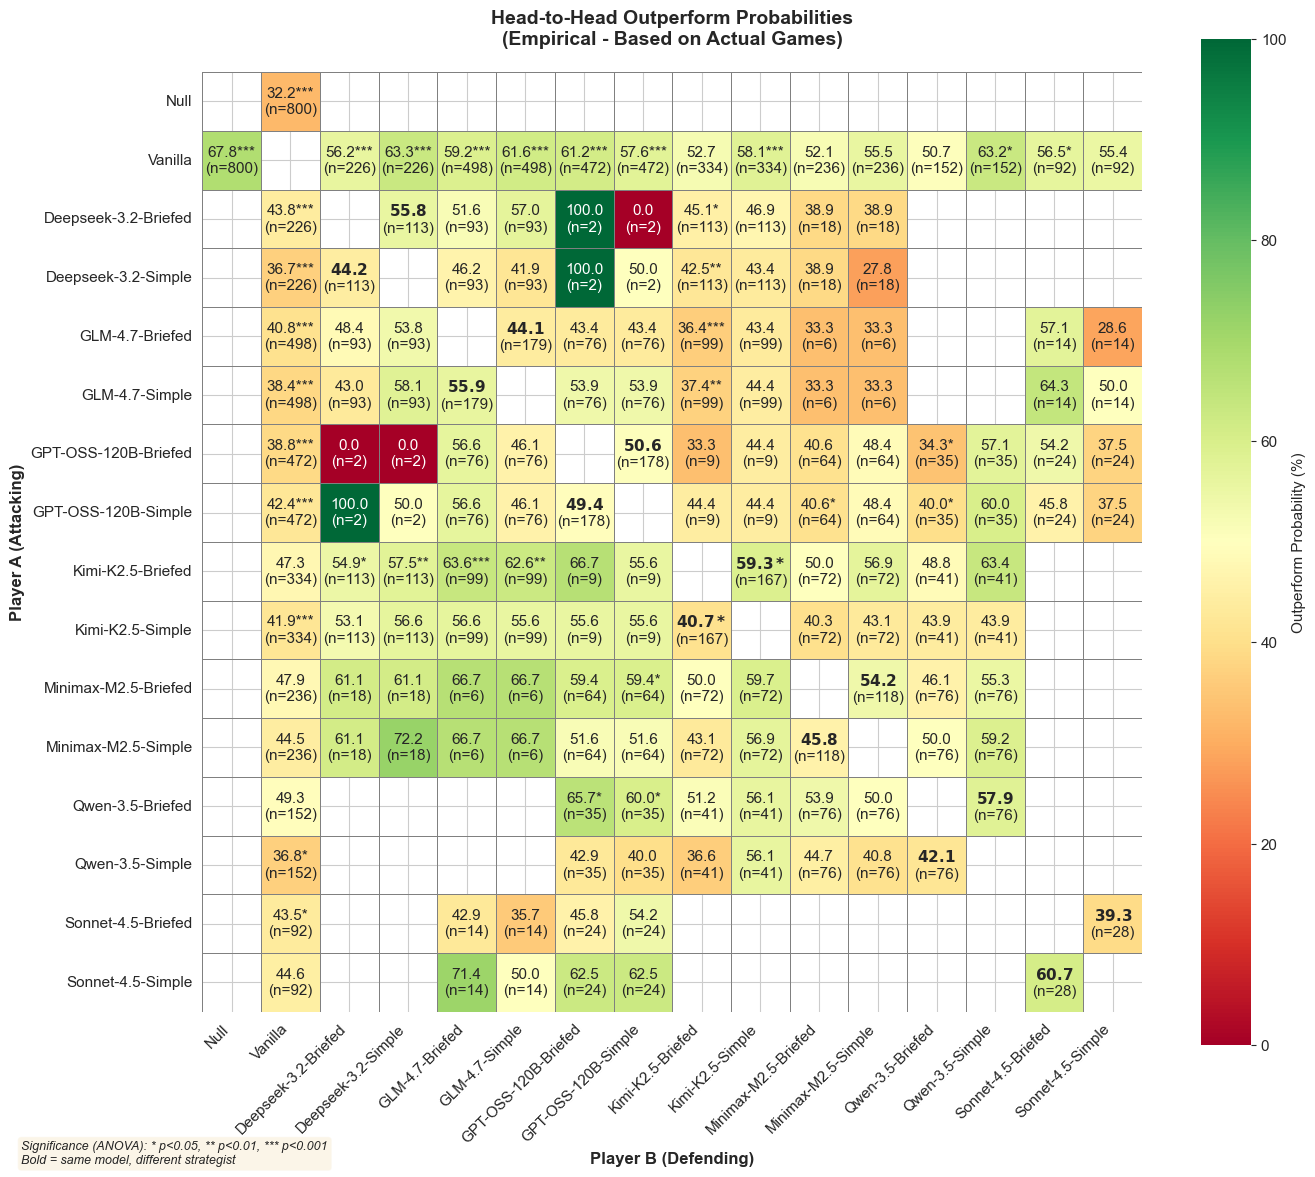


MATCHUP ANALYSIS

Deepseek-3.2-Briefed:
  vs Vanilla: 43.8% (n=226)
  Best matchup: vs GPT-OSS-120B-Briefed (100.0%, n=2)
  Worst matchup: vs GPT-OSS-120B-Simple (0.0%, n=2)

Deepseek-3.2-Simple:
  vs Vanilla: 36.7% (n=226)
  Best matchup: vs GPT-OSS-120B-Briefed (100.0%, n=2)
  Worst matchup: vs Minimax-M2.5-Simple (27.8%, n=18)

GLM-4.7-Briefed:
  vs Vanilla: 40.8% (n=498)
  Best matchup: vs Sonnet-4.5-Briefed (57.1%, n=14)
  Worst matchup: vs Sonnet-4.5-Simple (28.6%, n=14)

GLM-4.7-Simple:
  vs Vanilla: 38.4% (n=498)
  Best matchup: vs Sonnet-4.5-Briefed (64.3%, n=14)
  Worst matchup: vs Minimax-M2.5-Briefed (33.3%, n=6)

GPT-OSS-120B-Briefed:
  vs Vanilla: 38.8% (n=472)
  Best matchup: vs Qwen-3.5-Simple (57.1%, n=35)
  Worst matchup: vs Deepseek-3.2-Briefed (0.0%, n=2)

GPT-OSS-120B-Simple:
  vs Vanilla: 42.4% (n=472)
  Best matchup: vs Deepseek-3.2-Briefed (100.0%, n=2)
  Worst matchup: vs Sonnet-4.5-Simple (37.5%, n=24)

Kimi-K2.5-Briefed:
  vs Vanilla: 47.3% (n=334)
  Best ma

C:\Users\John Chen\AppData\Local\Temp\ipykernel_468300\3412172074.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [101]:
# =====================================================
# HEAD-TO-HEAD MATCHUP MATRIX
# =====================================================
# Calculate empirical pairwise outperform probabilities between all player types
# based on actual game data

from ratings import create_matchup_matrix
from plot_utilities import plot_matchup_heatmap

# strength_df = strength_df[strength_df['player_type'] != 'Null']

# Create matchup matrix using actual game data from strength_df
matchup_matrix_df, count_matrix_df, pvalue_matrix_df = create_matchup_matrix(
    strength_df,
    verbose=True
)

# Visualize as heatmap with percentages and match counts
fig, ax = plot_matchup_heatmap(
    matchup_matrix_df,
    count_df=count_matrix_df,
    pvalue_df=pvalue_matrix_df,
    title="Head-to-Head Outperform Probabilities\n(Empirical - Based on Actual Games)",
    figsize=(14, 12),
    as_percentage=True
)

plt.show()

# Matchup analysis with Vanilla baseline
print("\n" + "=" * 60)
print("MATCHUP ANALYSIS")
print("=" * 60)

for player in matchup_matrix_df.index:
    if player == 'Vanilla':
        continue  # Skip baseline
    
    # Find best matchup (highest outperform probability against non-self)
    matchups = matchup_matrix_df.loc[player]
    matchups_filtered = matchups[matchups.index != player].dropna()
    
    if len(matchups_filtered) == 0:
        continue
    
    best_opponent = matchups_filtered.idxmax()
    best_prob = matchups_filtered.max()
    best_count = count_matrix_df.loc[player, best_opponent]
    
    worst_opponent = matchups_filtered.idxmin()
    worst_prob = matchups_filtered.min()
    worst_count = count_matrix_df.loc[player, worst_opponent]
    
    # Get matchup vs Vanilla
    vanilla_prob = matchup_matrix_df.loc[player, 'Vanilla']
    vanilla_count = count_matrix_df.loc[player, 'Vanilla']
    
    print(f"\n{player}:")
    if pd.notna(vanilla_prob):
        print(f"  vs Vanilla: {vanilla_prob*100:.1f}% (n={int(vanilla_count)})")
    else:
        print(f"  vs Vanilla: No data")
    print(f"  Best matchup: vs {best_opponent} ({best_prob*100:.1f}%, n={int(best_count)})")
    print(f"  Worst matchup: vs {worst_opponent} ({worst_prob*100:.1f}%, n={int(worst_count)})")

HEAD-TO-HEAD MATCHUP MATRIX (MEAN STRENGTH DIFFERENCE)

Matrix dimensions: 16x16
Player types: 16
Total games analyzed: 357

Interpretation:
  - Rows: Player A
  - Columns: Player B
  - Value: Mean(A_adjusted_strength - B_adjusted_strength)
  - Positive = A is stronger on average
  - P-values: One-sample t-test (H0: mean diff = 0)


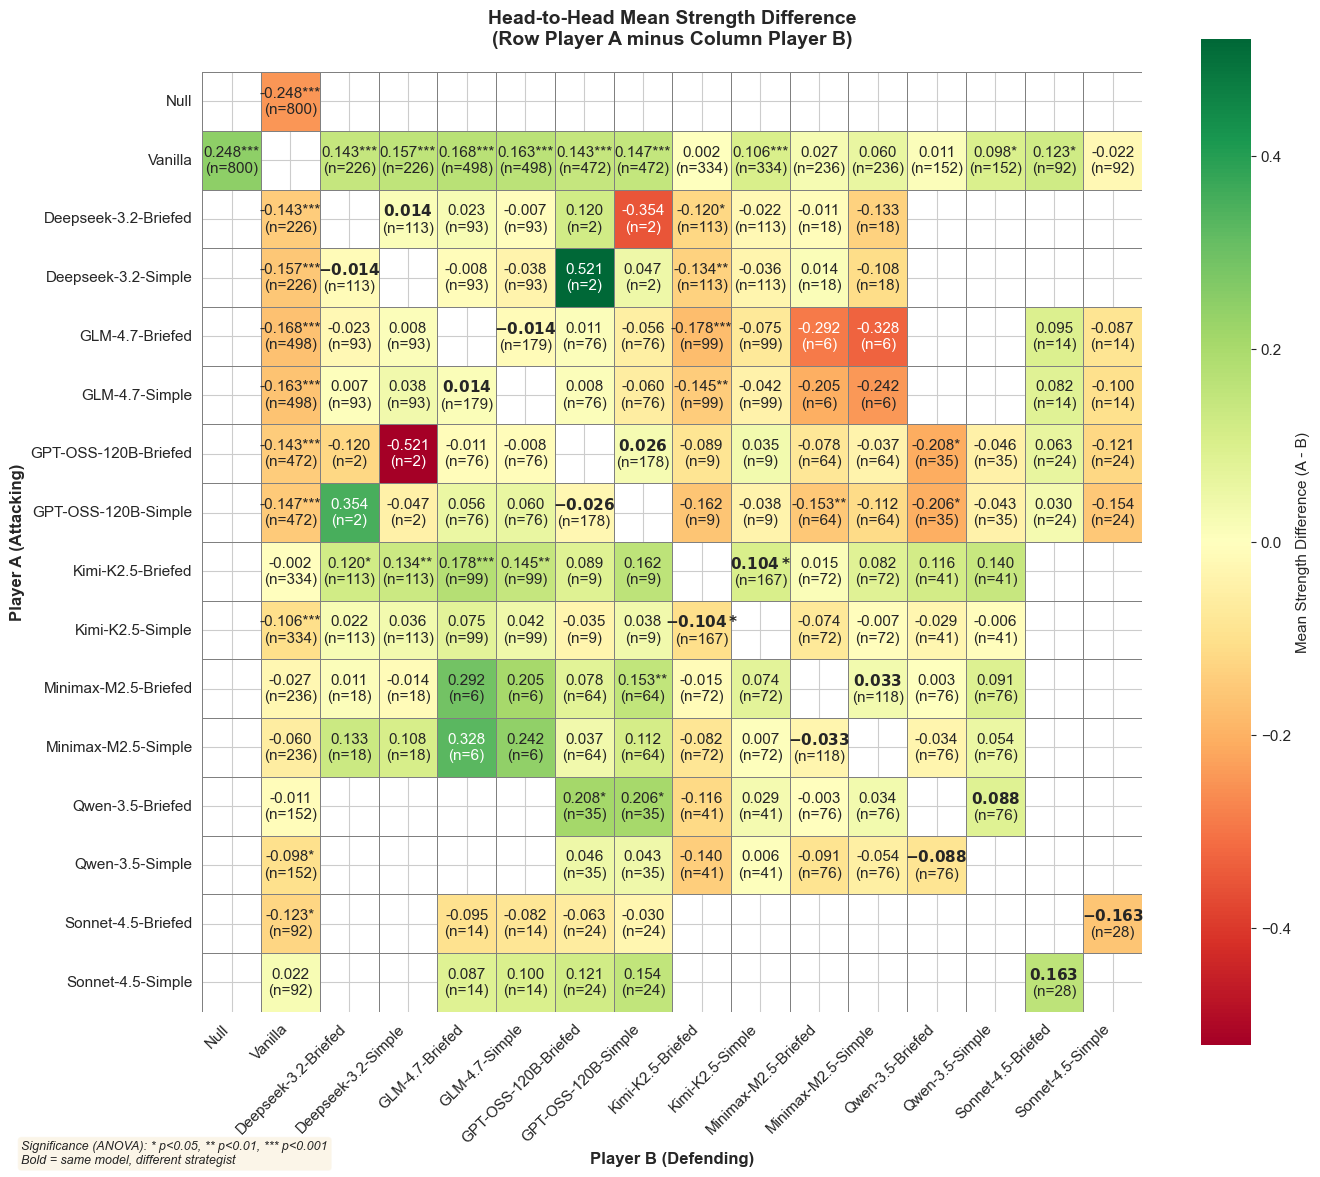


WIN-RATE vs MEAN-DIFFERENCE DISAGREEMENTS
Cases where win rate and mean difference point in opposite directions:

  Deepseek-3.2-Briefed vs GLM-4.7-Simple:
    Win rate: 57.0% | Mean diff: -0.0071 | n=93
  Deepseek-3.2-Simple vs Minimax-M2.5-Briefed:
    Win rate: 38.9% | Mean diff: +0.0143 | n=18
  GLM-4.7-Briefed vs GPT-OSS-120B-Briefed:
    Win rate: 43.4% | Mean diff: +0.0113 | n=76
  GLM-4.7-Simple vs Deepseek-3.2-Briefed:
    Win rate: 43.0% | Mean diff: +0.0071 | n=93
  GLM-4.7-Simple vs GPT-OSS-120B-Simple:
    Win rate: 53.9% | Mean diff: -0.0596 | n=76
  GPT-OSS-120B-Briefed vs GLM-4.7-Briefed:
    Win rate: 56.6% | Mean diff: -0.0113 | n=76
  GPT-OSS-120B-Briefed vs Kimi-K2.5-Simple:
    Win rate: 44.4% | Mean diff: +0.0349 | n=9
  GPT-OSS-120B-Briefed vs Qwen-3.5-Simple:
    Win rate: 57.1% | Mean diff: -0.0456 | n=35
  GPT-OSS-120B-Simple vs GLM-4.7-Simple:
    Win rate: 46.1% | Mean diff: +0.0596 | n=76
  GPT-OSS-120B-Simple vs Qwen-3.5-Simple:
    Win rate: 60.0% | Mean

C:\Users\John Chen\AppData\Local\Temp\ipykernel_468300\1770123103.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [102]:
# =====================================================
# HEAD-TO-HEAD MATCHUP MATRIX (MEAN STRENGTH DIFFERENCE)
# =====================================================
# Complement the win-rate matrix with mean strength differences.
# A player can win <50% of comparisons but still be stronger on average
# (e.g., winning by small margins, losing by large ones).

from ratings import create_mean_matchup_matrix

mean_diff_df, mean_count_df, mean_pvalue_df = create_mean_matchup_matrix(
    strength_df,
    verbose=True
)

# Symmetric colormap range centered at 0
abs_max = np.nanmax(np.abs(mean_diff_df.values))

fig, ax = plot_matchup_heatmap(
    mean_diff_df,
    count_df=mean_count_df,
    pvalue_df=mean_pvalue_df,
    title="Head-to-Head Mean Strength Difference\n(Row Player A minus Column Player B)",
    figsize=(14, 12),
    as_percentage=False,
    vmin=-abs_max,
    vmax=abs_max,
    center=0,
    cbar_label='Mean Strength Difference (A - B)',
    annot_format='.3f'
)

plt.show()

# Compare win-rate vs mean-difference: flag disagreements
print("\n" + "=" * 60)
print("WIN-RATE vs MEAN-DIFFERENCE DISAGREEMENTS")
print("=" * 60)
print("Cases where win rate and mean difference point in opposite directions:\n")

found = False
for a in matchup_matrix_df.index:
    for b in matchup_matrix_df.columns:
        if a == b:
            continue
        wr = matchup_matrix_df.loc[a, b]
        md = mean_diff_df.loc[a, b]
        if pd.isna(wr) or pd.isna(md):
            continue
        # Win rate says A wins more often, but mean says A is weaker (or vice versa)
        if (wr > 0.5 and md < 0) or (wr < 0.5 and md > 0):
            n = int(mean_count_df.loc[a, b])
            found = True
            print(f"  {a} vs {b}:")
            print(f"    Win rate: {wr*100:.1f}% | Mean diff: {md:+.4f} | n={n}")

if not found:
    print("  None found — win rate and mean difference agree for all pairs.")

In [103]:
# =====================================================
# OUTLIERS: ELO vs HEAD-TO-HEAD DISAGREEMENTS
# =====================================================
# Identify pairs where the Elo-stronger player actually loses
# head-to-head — either by win probability or mean strength difference.
# These cases reveal intransitivity in the competitive landscape.

# Build Elo lookup from BT rating summary
elo_lookup = rating_summary_df.set_index('player_type')['elo'].to_dict()

rows = []
player_types = matchup_matrix_df.index.tolist()

for a in player_types:
    for b in player_types:
        if a >= b:  # avoid duplicates and self-comparisons (lexicographic)
            continue

        elo_a, elo_b = elo_lookup.get(a), elo_lookup.get(b)
        if elo_a is None or elo_b is None:
            continue

        # Determine who has higher Elo
        if elo_a >= elo_b:
            higher, lower = a, b
            elo_diff = elo_a - elo_b
        else:
            higher, lower = b, a
            elo_diff = elo_b - elo_a

        # Get H2H stats (row=higher Elo player, col=lower)
        wr = matchup_matrix_df.loc[higher, lower]
        md = mean_diff_df.loc[higher, lower]
        if pd.isna(wr) and pd.isna(md):
            continue

        n = count_matrix_df.loc[higher, lower] if pd.notna(wr) else mean_count_df.loc[higher, lower]
        wr_pval = pvalue_matrix_df.loc[higher, lower] if pd.notna(wr) else np.nan
        md_pval = mean_pvalue_df.loc[higher, lower] if pd.notna(md) else np.nan

        # Check for disagreement
        wr_disagrees = pd.notna(wr) and wr < 0.5
        md_disagrees = pd.notna(md) and md < 0

        if wr_disagrees or md_disagrees:
            disagree_flags = []
            if wr_disagrees:
                disagree_flags.append('Win Rate')
            if md_disagrees:
                disagree_flags.append('Mean Diff')

            rows.append({
                'Higher Elo': higher,
                'Lower Elo': lower,
                'Elo Diff': f'{elo_diff:.0f}',
                'H2H Win%': f'{wr*100:.1f}%' if pd.notna(wr) else '—',
                'H2H p-val': f'{wr_pval:.3f}' if pd.notna(wr_pval) else '—',
                'Mean Δ': f'{md:+.4f}' if pd.notna(md) else '—',
                'Mean p-val': f'{md_pval:.3f}' if pd.notna(md_pval) else '—',
                'n': int(n),
                'Disagrees On': ' + '.join(disagree_flags),
            })

print("=" * 80)
print("ELO vs HEAD-TO-HEAD DISAGREEMENTS")
print("=" * 80)
print("Pairs where the higher-Elo player loses head-to-head (by win% or mean diff):\n")

if rows:
    outlier_df = pd.DataFrame(rows)
    outlier_df = outlier_df.sort_values('n', ascending=False)
    display(outlier_df.reset_index(drop=True).style.set_caption(
        f'{len(outlier_df)} outlier pair(s) found'
    ))
else:
    print("  None found — Elo rankings agree with all head-to-head outcomes.")

ELO vs HEAD-TO-HEAD DISAGREEMENTS
Pairs where the higher-Elo player loses head-to-head (by win% or mean diff):




CIV-ADJUSTED WIN PROBABILITY: VALIDATION

Original mean: 0.1250
Adjusted mean: 0.1449

Original std: 0.1744
Adjusted std: 0.2133

Adjustment range: [-0.6294, 0.7063]
Mean adjustment magnitude: 0.1162


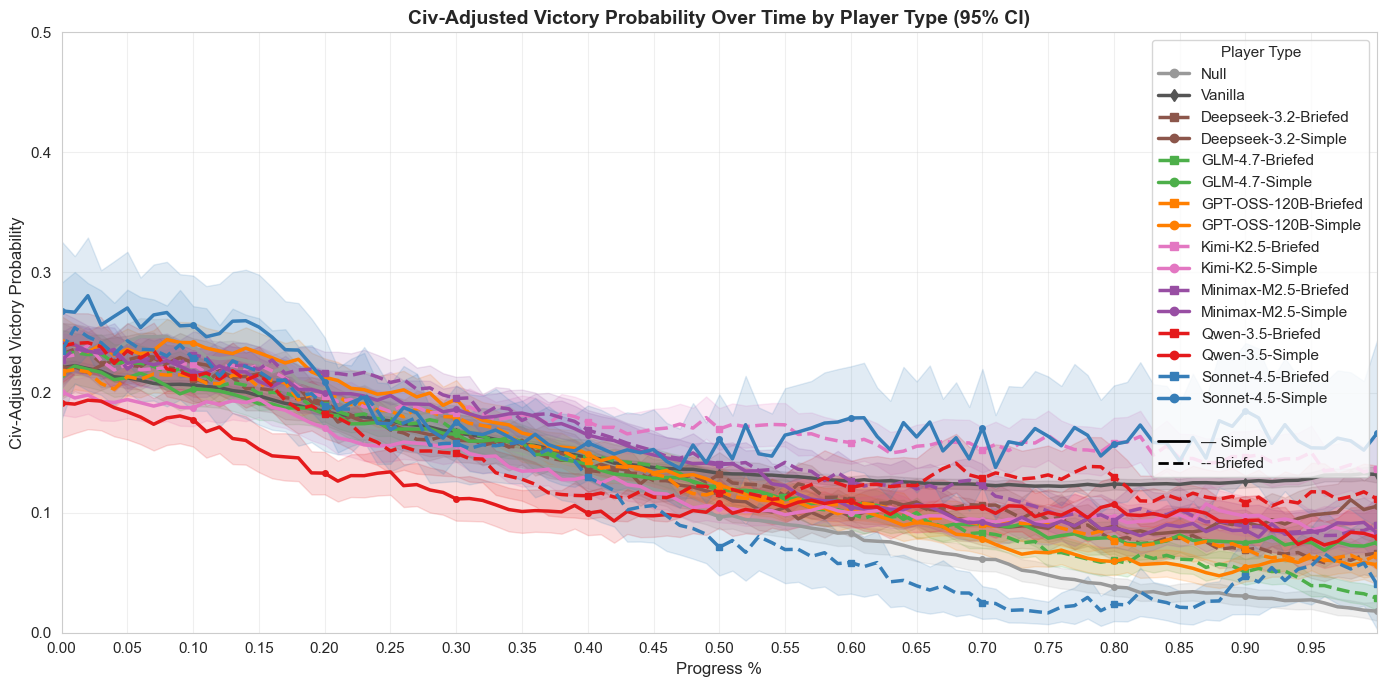

N   Mean    Std  Min    Max     Slope      r
Null                    89336  0.118  0.187  0.0  0.972 -0.253405 -0.393
Vanilla               1076064  0.151  0.219  0.0  1.000 -0.098686 -0.130
Deepseek-3.2-Briefed    48321  0.135  0.205  0.0  0.994 -0.175118 -0.248
Deepseek-3.2-Simple     48321  0.137  0.223  0.0  1.000 -0.156650 -0.203
GLM-4.7-Briefed         75725  0.127  0.196  0.0  1.000 -0.206304 -0.304
GLM-4.7-Simple          75725  0.130  0.195  0.0  0.996 -0.162477 -0.241
GPT-OSS-120B-Briefed    65948  0.133  0.195  0.0  0.965 -0.179594 -0.267
GPT-OSS-120B-Simple     65948  0.135  0.199  0.0  0.995 -0.226910 -0.329
Kimi-K2.5-Briefed       71212  0.175  0.242  0.0  1.000 -0.087579 -0.105
Kimi-K2.5-Simple        71212  0.127  0.197  0.0  1.000 -0.121443 -0.178
Minimax-M2.5-Briefed    50190  0.154  0.209  0.0  0.995 -0.175244 -0.242
Minimax-M2.5-Simple     50190  0.145  0.213  0.0  1.000 -0.177269 -0.240
Qwen-3.5-Briefed        32340  0.144  0.204  0.0  0.981 -0.111210 -0.157
Qwen-3.5-Simple         32340  0.116  0.186  0.0  1.000 -0.087117 -0.136
Sonnet-4.5-Briefed      11192  0.106  0.178  0.0  0.974 -0.245735 -0.396
Sonnet-4.5-Simple       11192  0.180  0.236  0.0  0.996 -0.092521 -0.112

In [104]:
# =====================================================
# CIV-ADJUSTED VICTORY PROBABILITY OVER TIME
# =====================================================
# Apply civilization adjustments (from Cell 12) to predicted_win_probability
# and visualize how player types perform when civilization bias is removed.
# Adjustment is done in logit (log-odds) space so that civ effects are
# proportional: a strong civ helps a strong player more than a weak one,
# and outputs stay bounded in (0, 1).

from plot_utilities import logit, inv_logit

# Apply civ_effects in logit space, then back-transform
civ_adj = turn_df['civilization'].map(civ_effects).fillna(0)
turn_df['civ_adjusted_win_prob'] = inv_logit(
    logit(turn_df['predicted_win_probability']) - civ_adj
)

# Validation checks
print("\n" + "=" * 60)
print("CIV-ADJUSTED WIN PROBABILITY: VALIDATION")
print("=" * 60)
print(f"\nOriginal mean: {turn_df['predicted_win_probability'].mean():.4f}")
print(f"Adjusted mean: {turn_df['civ_adjusted_win_prob'].mean():.4f}")
print(f"\nOriginal std: {turn_df['predicted_win_probability'].std():.4f}")
print(f"Adjusted std: {turn_df['civ_adjusted_win_prob'].std():.4f}")

adjustment_range = turn_df['predicted_win_probability'] - turn_df['civ_adjusted_win_prob']
print(f"\nAdjustment range: [{adjustment_range.min():.4f}, {adjustment_range.max():.4f}]")
print(f"Mean adjustment magnitude: {adjustment_range.abs().mean():.4f}")

# Plot civ-adjusted win probability over time
fig, ax = plot_metric_over_time(
    turn_df,
    metric_calculation=lambda df: df['civ_adjusted_win_prob'],
    title="Civ-Adjusted Victory Probability Over Time by Player Type",
    ylabel="Civ-Adjusted Victory Probability",
    figsize=(14, 7),
    show_confidence=True,
    confidence_level=0.95,
    print_summary=True,
    use_turn_progress=True,
    ylim=(0, 0.5)
)